In [1]:
import pandas as pd
df = pd.read_csv("D:/Tugas Akhir/Codingan/Development/App/data/df_train_YESUSFIX.csv")
df.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,total_income_work,income_dependant_ratio,work_efficiency,active_work_category,work_stability_score,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance
0,EM13274,Kota Jakarta Timur,Perempuan,1999-01-23,2021-11-30,2023-02-02,Single,0,D2,4.0,...,4.341320e+07,3.100943e+06,1.12750,Mid-term,2.800000,1,3.100943e+06,3,1.033648e+06,1.8
1,EM10730,Tangerang,Laki-laki,1998-04-12,2023-01-31,2024-03-16,Single,0,SLTA,2.0,...,1.489849e+07,1.146038e+06,1.22500,Mid-term,4.333333,1,1.146038e+06,1,1.146038e+06,2.6
2,EM4510,Kabupaten Bekasi,Laki-laki,1981-06-10,2021-10-30,2023-12-15,Married,2,SLTA,0.0,...,2.003449e+08,2.671265e+06,1.18125,Mid-term,25.000000,4,2.003449e+06,1,8.013796e+06,3.0
3,EM2622,Kabupaten Bekasi,Laki-laki,1981-07-26,2021-09-13,2023-10-31,Married,3,SLTA,0.0,...,2.537505e+08,2.537505e+06,1.22000,Mid-term,25.000000,4,2.537505e+06,1,1.015002e+07,4.0
4,EM0633,Kota Jakarta Pusat,Laki-laki,1988-07-07,2022-08-22,2023-10-01,Married,1,SLTA,8.0,...,3.312456e+07,1.274022e+06,1.18250,Mid-term,1.444444,1,2.548043e+06,1,2.548043e+06,1.8


In [2]:
len(df)

12288

In [3]:
df['churn_status'].value_counts()

churn_status
0    9265
1    3023
Name: count, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split

cat_feature = ['departemen', 'position', 'domisili', 'marriage_stat', 'job_satisfaction', 'performance_rating',
               'education', 'active_work_category', 'jenis_kelamin']

X = df.drop(columns=['churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date', 'active_work_months'])
y = df['churn_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
print("Training: ", y_train.value_counts())
print("Testing: ", y_test.value_counts())

Training:  churn_status
0    7412
1    2418
Name: count, dtype: int64
Testing:  churn_status
0    1853
1     605
Name: count, dtype: int64


In [6]:
len(X_train)

9830

In [7]:
len(X_test)

2458

In [8]:
from catboost import CatBoostClassifier
import pandas as pd

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    cat_features= cat_feature,
    loss_function='Logloss',
    eval_metric='AUC',
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    verbose=200
)

# Melatih model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	test: 0.9470753	best: 0.9470753 (0)	total: 295ms	remaining: 4m 54s
200:	test: 0.9734485	best: 0.9734485 (200)	total: 21.1s	remaining: 1m 23s
400:	test: 0.9768800	best: 0.9768889 (399)	total: 40.8s	remaining: 1m 1s
600:	test: 0.9777925	best: 0.9777952 (599)	total: 58.3s	remaining: 38.7s
800:	test: 0.9783991	best: 0.9783991 (800)	total: 1m 17s	remaining: 19.3s
999:	test: 0.9789218	best: 0.9789218 (999)	total: 1m 35s	remaining: 0us

bestTest = 0.9789218288
bestIteration = 999



In [10]:
!pip install optuna

  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached greenlet-3.1.1-cp310-cp310-win_amd64.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.1 MB 2.4 MB/s eta 0:00:01
   ------------------------ --------------- 1.3/2.1 MB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 2.8 MB/s eta 0:00:00
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
Using cached PyYAML-6.0.2-cp310-cp310-win_amd64.whl (161 kB)
Using cached greenlet-3.1.1-cp310-cp310-win_amd64.whl (298 kB)


In [11]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Fungsi objective untuk Optuna
def objective(trial):
    # Definisikan parameter yang akan dioptimasi
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 6),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 20),
        'random_strength': trial.suggest_float('random_strength', 5, 10),
        'cat_features': cat_feature,
        'loss_function': 'Logloss',
        'random_state': 42,
        'verbose': 0
    }

    # Inisialisasi model dengan parameter yang dioptimasi
    model = CatBoostClassifier(**params)

    # Melatih model dengan validasi
    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

    # Prediksi probabilitas untuk menghitung AUC
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)

    return auc  # Mengembalikan AUC sebagai skor yang ingin dimaksimalkan

d:\Tugas Akhir\Codingan\Development\App\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Buat studi Optuna untuk memaksimalkan AUC
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Lakukan 20 percobaan

# Tampilkan hasil terbaik
print("Best Trial:")
print(f"AUC: {study.best_trial.value}")
print("Params:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

[I 2025-03-20 14:04:16,096] A new study created in memory with name: no-name-a08ce526-8628-4eb7-a8f0-b10a4d1fdfcf
[I 2025-03-20 14:05:09,743] Trial 0 finished with value: 0.9679634989942599 and parameters: {'iterations': 712, 'learning_rate': 0.00808789111583903, 'depth': 5, 'subsample': 0.7534855215992657, 'colsample_bylevel': 0.6718129120534164, 'l2_leaf_reg': 14.932552759777428, 'random_strength': 6.218629002335594}. Best is trial 0 with value: 0.9679634989942599.
[I 2025-03-20 14:06:13,092] Trial 1 finished with value: 0.9791885394691654 and parameters: {'iterations': 997, 'learning_rate': 0.08810482292857882, 'depth': 4, 'subsample': 0.6997259087320504, 'colsample_bylevel': 0.618232755190445, 'l2_leaf_reg': 13.679013578868982, 'random_strength': 5.906123359684791}. Best is trial 1 with value: 0.9791885394691654.
[I 2025-03-20 14:07:15,582] Trial 2 finished with value: 0.9797460450553714 and parameters: {'iterations': 729, 'learning_rate': 0.033511049626555336, 'depth': 6, 'subsamp

Best Trial:
AUC: 0.9797460450553714
Params:
  iterations: 729
  learning_rate: 0.033511049626555336
  depth: 6
  subsample: 0.7224685767241121
  colsample_bylevel: 0.7533870049652309
  l2_leaf_reg: 8.860553490367955
  random_strength: 7.587105821853806


In [13]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Ambil parameter terbaik dari Optuna
best_params = study.best_trial.params

# Tambahkan parameter tetap (yang tidak dioptimasi)
best_params.update({
    'loss_function': 'Logloss',  # Masih pakai Logloss untuk training
    'eval_metric': 'AUC',        # Pakai AUC untuk evaluasi
    'cat_features': cat_feature,
    'random_state': 42,
    'verbose': 100,  # Set verbose ke 100 agar terlihat AUC setiap 100 iterasi
    'od_type': 'Iter',
    'od_wait': 50
})

# Latih model dengan parameter terbaik
final_model = CatBoostClassifier(**best_params)

final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True, 
    verbose=100  # AUC akan ditampilkan setiap 100 iterasi
)

# Dapatkan prediksi probabilitas
y_pred_train = final_model.predict_proba(X_train)[:, 1]  # Untuk training set
y_pred_test = final_model.predict_proba(X_test)[:, 1]  # Untuk testing set

# Hitung AUC untuk training dan testing
train_auc = roc_auc_score(y_train, y_pred_train)
test_auc = roc_auc_score(y_test, y_pred_test)

# Cetak skor AUC setelah training selesai
print(f"Learn AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f}")

0:	test: 0.9386249	best: 0.9386249 (0)	total: 135ms	remaining: 1m 37s
100:	test: 0.9658378	best: 0.9660823 (80)	total: 8.33s	remaining: 51.8s
200:	test: 0.9678520	best: 0.9678672 (199)	total: 18.7s	remaining: 49.2s
300:	test: 0.9710061	best: 0.9710302 (297)	total: 26.4s	remaining: 37.5s
400:	test: 0.9775258	best: 0.9775258 (400)	total: 33.7s	remaining: 27.6s
500:	test: 0.9789557	best: 0.9789557 (500)	total: 42.5s	remaining: 19.3s
600:	test: 0.9794062	best: 0.9794347 (579)	total: 51.7s	remaining: 11s
700:	test: 0.9796720	best: 0.9797166 (680)	total: 1m 2s	remaining: 2.5s
728:	test: 0.9797443	best: 0.9797460 (722)	total: 1m 5s	remaining: 0us

bestTest = 0.9797460451
bestIteration = 722

Shrink model to first 723 iterations.
Learn AUC: 0.9869 | Test AUC: 0.9797


Final Training Logloss: 0.1271368948276341
Final Validation Logloss: 0.1558541739979401


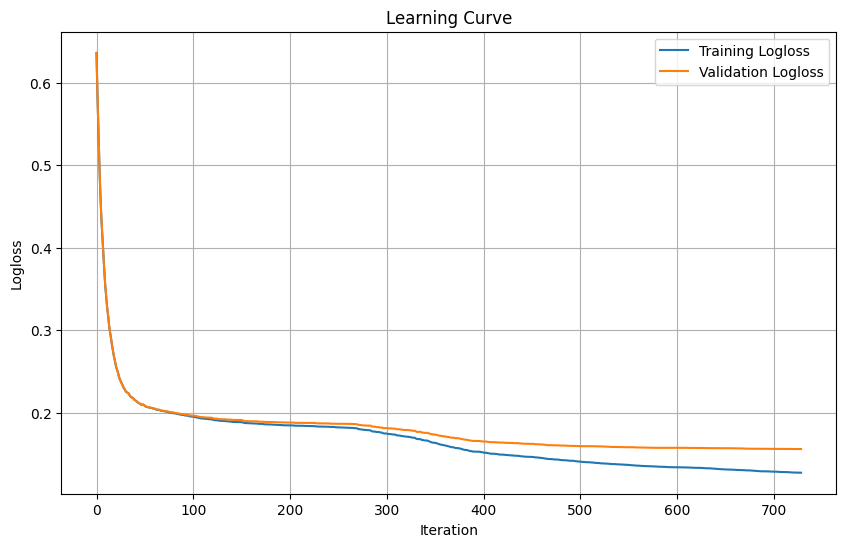

In [14]:
evals_result = final_model.get_evals_result()

# Menampilkan skor terakhir
train_score = evals_result['learn']['Logloss'][-1]
val_score = evals_result['validation']['Logloss'][-1]

print(f"Final Training Logloss: {train_score}")
print(f"Final Validation Logloss: {val_score}")

import matplotlib.pyplot as plt

# Ambil skor training dan validation dari evals_result
train_logloss = evals_result['learn']['Logloss']
val_logloss = evals_result['validation']['Logloss']

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label='Training Logloss')
plt.plot(val_logloss, label='Validation Logloss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

Final Training Logloss: 0.14482801515145513
Final Validation Logloss: 0.1703206692296592


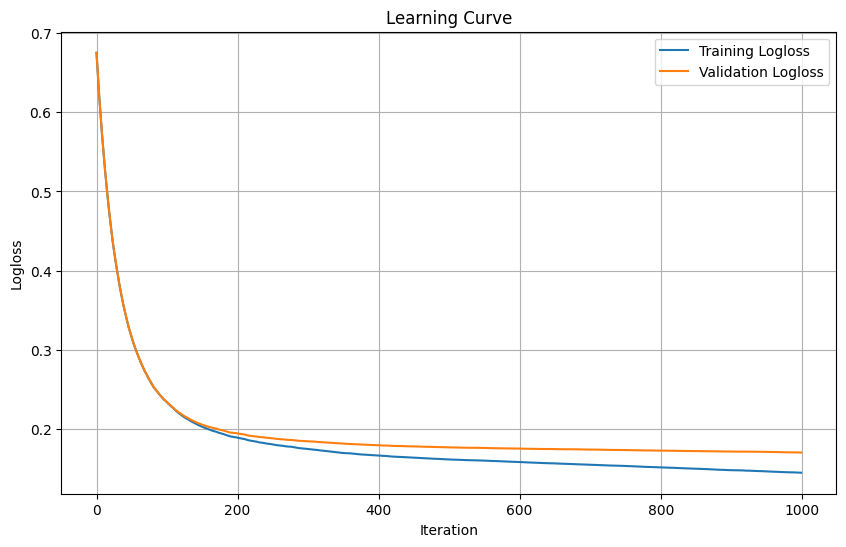

In [15]:
evals_result = model.get_evals_result()

# Menampilkan skor terakhir
train_score = evals_result['learn']['Logloss'][-1]
val_score = evals_result['validation']['Logloss'][-1]

print(f"Final Training Logloss: {train_score}")
print(f"Final Validation Logloss: {val_score}")

import matplotlib.pyplot as plt

# Ambil skor training dan validation dari evals_result
train_logloss = evals_result['learn']['Logloss']
val_logloss = evals_result['validation']['Logloss']

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label='Training Logloss')
plt.plot(val_logloss, label='Validation Logloss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

0:	total: 75.1ms	remaining: 1m 15s
200:	total: 11.2s	remaining: 44.7s
400:	total: 22.6s	remaining: 33.8s
600:	total: 37.4s	remaining: 24.8s
800:	total: 55.8s	remaining: 13.9s
999:	total: 1m 8s	remaining: 0us
0:	total: 47.9ms	remaining: 47.8s
200:	total: 11.2s	remaining: 44.6s
400:	total: 23.9s	remaining: 35.7s
600:	total: 45.2s	remaining: 30s
800:	total: 56.4s	remaining: 14s
999:	total: 1m 8s	remaining: 0us
0:	total: 49.7ms	remaining: 49.6s
200:	total: 11.2s	remaining: 44.3s
400:	total: 24.4s	remaining: 36.4s
600:	total: 44.3s	remaining: 29.4s
800:	total: 59.1s	remaining: 14.7s
999:	total: 1m 10s	remaining: 0us
0:	total: 56.3ms	remaining: 56.2s
200:	total: 11.7s	remaining: 46.7s
400:	total: 28.1s	remaining: 42s
600:	total: 47.9s	remaining: 31.8s
800:	total: 1m	remaining: 15.1s
999:	total: 1m 11s	remaining: 0us
0:	total: 47.6ms	remaining: 47.5s
200:	total: 11.4s	remaining: 45.3s
400:	total: 28.8s	remaining: 43.1s
600:	total: 49.4s	remaining: 32.8s
800:	total: 1m 1s	remaining: 15.3s
999:

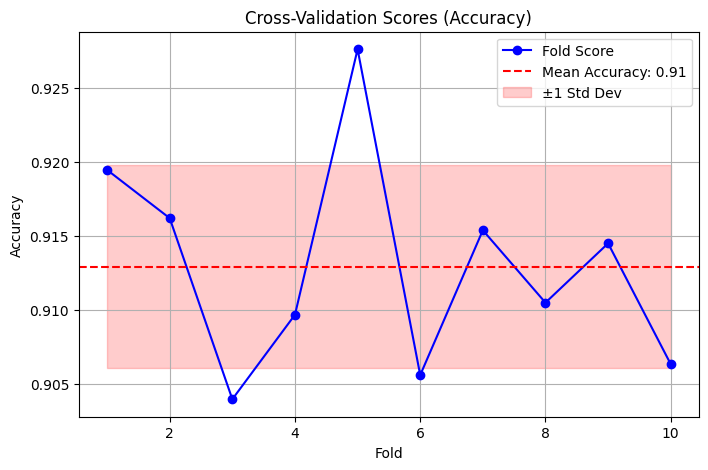

Accuracy Scores for each fold: [0.9194467  0.91619203 0.90398698 0.90968267 0.9275834  0.90561432
 0.91537836 0.91049634 0.91449511 0.90635179]
Mean Accuracy: 0.91
Standard Deviation: 0.01


In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Fungsi untuk menghitung skor cross-validation dan visualisasi
def cross_validate_and_visualize_accuracy(model, X, y, cv=10):
    # Stratified K-Fold untuk mempertahankan distribusi label
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Hitung skor cross-validation dengan metrik akurasi
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=skf)

    # Rata-rata dan standar deviasi
    mean_score = np.mean(scores)
    std_score = np.std(scores)

    # Visualisasi hasil cross-validation
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, cv + 1), scores, marker='o', linestyle='-', color='b', label='Fold Score')
    plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean Accuracy: {mean_score:.2f}')
    plt.fill_between(range(1, cv + 1), mean_score - std_score, mean_score + std_score, color='r', alpha=0.2, label='±1 Std Dev')
    plt.title('Cross-Validation Scores (Accuracy)')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Cetak hasil skor
    print(f'Accuracy Scores for each fold: {scores}')
    print(f'Mean Accuracy: {mean_score:.2f}')
    print(f'Standard Deviation: {std_score:.2f}')

# Contoh penggunaan
# Ganti model dengan model Anda, misalnya `model`
cross_validate_and_visualize_accuracy(model, X, y, cv=10)

0:	total: 67.4ms	remaining: 49.1s
100:	total: 9.39s	remaining: 58.4s
200:	total: 18.2s	remaining: 47.8s
300:	total: 26.9s	remaining: 38.3s
400:	total: 34.6s	remaining: 28.3s
500:	total: 42.3s	remaining: 19.3s
600:	total: 51.5s	remaining: 11s
700:	total: 1m 5s	remaining: 2.62s
728:	total: 1m 9s	remaining: 0us
0:	total: 117ms	remaining: 1m 25s
100:	total: 15.1s	remaining: 1m 33s
200:	total: 22.7s	remaining: 59.8s
300:	total: 28.5s	remaining: 40.5s
400:	total: 34.7s	remaining: 28.4s
500:	total: 41.8s	remaining: 19s
600:	total: 48.6s	remaining: 10.4s
700:	total: 56.4s	remaining: 2.25s
728:	total: 59.5s	remaining: 0us
0:	total: 101ms	remaining: 1m 13s
100:	total: 9.68s	remaining: 1m
200:	total: 18.7s	remaining: 49.1s
300:	total: 30.8s	remaining: 43.8s
400:	total: 41.4s	remaining: 33.9s
500:	total: 51.6s	remaining: 23.5s
600:	total: 59.2s	remaining: 12.6s
700:	total: 1m 7s	remaining: 2.69s
728:	total: 1m 10s	remaining: 0us
0:	total: 83.9ms	remaining: 1m 1s
100:	total: 9.63s	remaining: 59.9s


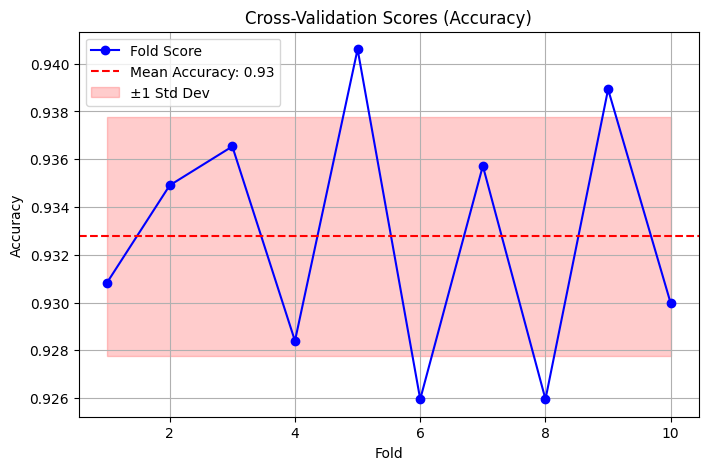

Accuracy Scores for each fold: [0.93083808 0.93490643 0.93653377 0.92839707 0.94060212 0.92595606
 0.9357201  0.92595606 0.93892508 0.92996743]
Mean Accuracy: 0.93
Standard Deviation: 0.01


In [17]:
cross_validate_and_visualize_accuracy(final_model, X, y, cv=10)

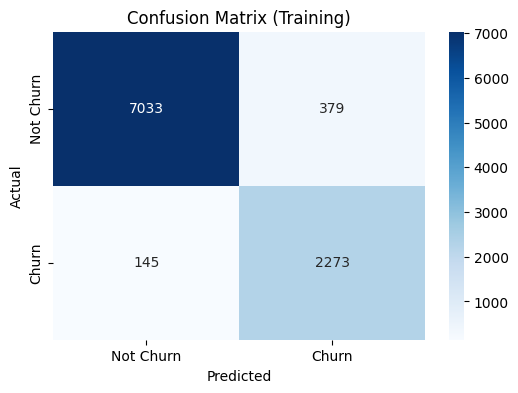

Training Metrics:
Accuracy: 0.95
Precision: 0.86
Recall: 0.94
F1 Score: 0.90
------------------------------


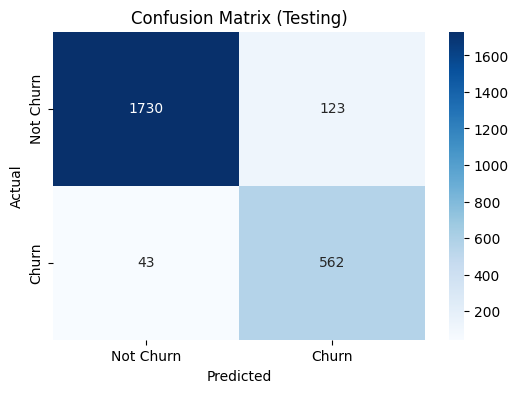

Testing Metrics:
Accuracy: 0.93
Precision: 0.82
Recall: 0.93
F1 Score: 0.87
------------------------------


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan confusion matrix dan metrik evaluasi
def evaluate_model(y_true, y_pred, dataset_name):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.show()
    
    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f'{dataset_name} Metrics:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('-' * 30)

# Prediksi untuk data training dan testing
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Evaluasi untuk data training
evaluate_model(y_train, y_train_pred, 'Training')

# Evaluasi untuk data testing
evaluate_model(y_test, y_test_pred, 'Testing')

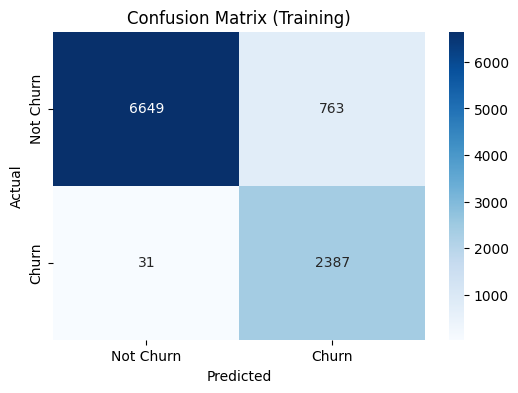

Training Metrics:
Accuracy: 0.92
Precision: 0.76
Recall: 0.99
F1 Score: 0.86
------------------------------


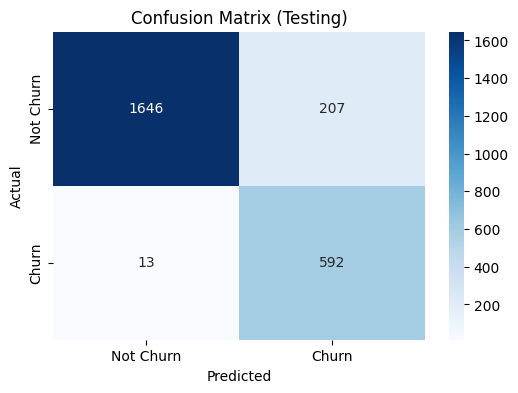

Testing Metrics:
Accuracy: 0.91
Precision: 0.74
Recall: 0.98
F1 Score: 0.84
------------------------------


In [19]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluasi untuk data training
evaluate_model(y_train, y_train_pred, 'Training')

# Evaluasi untuk data testing
evaluate_model(y_test, y_test_pred, 'Testing')

In [20]:
import pickle

with open('D:/Tugas Akhir/Codingan/Development/App/model/clasification_final_model_biasa.sav', 'wb') as f:
    pickle.dump(final_model, f)

with open('D:/Tugas Akhir/Codingan/Development/App/model/clasification_model_biasa.sav', 'wb') as f:
    pickle.dump(model, f)

In [21]:
df_test = pd.read_csv('D:/Tugas Akhir/Codingan/Development/App/data/df_test_YESUSFIX.csv')
df_test.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,total_income_work,income_dependant_ratio,work_efficiency,active_work_category,work_stability_score,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance
0,EM6407,Kota Jakarta Selatan,Laki-laki,1981-03-05,2022-03-13,2023-08-08,Married,3,D3,3.0,...,1.169413e+08,1.719725e+06,1.22500,Mid-term,4.250000,4,1.719725e+06,4,1.719725e+06,3.4
1,EM6881,Tangerang,Laki-laki,1974-04-26,2022-04-11,2023-05-31,Married,0,D3,2.0,...,1.369110e+08,1.053162e+07,1.17375,Mid-term,4.333333,4,2.632904e+06,4,2.632904e+06,4.0
2,EM9588,Kota Depok,Perempuan,1980-01-08,2022-02-22,2023-08-30,Married,3,D1,4.0,...,1.408170e+08,1.955791e+06,1.18625,Mid-term,3.600000,4,1.955791e+06,2,3.911582e+06,3.6
3,EM6817,Kota Jakarta Timur,Perempuan,1985-06-15,2021-09-04,2023-01-13,Married,2,SLTA,10.0,...,3.969525e+07,8.269843e+05,1.13125,Mid-term,1.454545,1,2.480953e+06,1,2.480953e+06,1.0
4,EM0933,Kota Jakarta Timur,Laki-laki,1981-10-31,2022-03-20,2024-09-08,Married,1,SLTA,7.0,...,2.918537e+08,4.864228e+06,1.14125,Mid-term,3.750000,4,2.432114e+06,1,9.728456e+06,4.0


In [22]:
df_test['churn_status'].value_counts()

churn_status
1    335
Name: count, dtype: int64

In [23]:
X_test = df_test.drop(['churn_status', 'employee_id', 'date_of_birth', 'join_date', 
                       'resign_date', 'active_work_months'], axis=1)

cat_feature = ['departemen', 'position', 'domisili', 'marriage_stat', 'job_satisfaction', 'performance_rating',
               'education', 'active_work_category', 'resign_risk_indicator', 'jenis_kelamin']

y_pred = final_model.predict(X_test)

X_test['predicted_churn'] = y_pred

accuracy = accuracy_score(df_test['churn_status'], y_pred)
precision = precision_score(df_test['churn_status'], y_pred, zero_division=0)
recall = recall_score(df_test['churn_status'], y_pred, zero_division=0)
f1 = f1_score(df_test['churn_status'], y_pred, zero_division=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8955223880597015
Precision: 1.0
Recall: 0.8955223880597015
F1 Score: 0.9448818897637795


In [24]:
X_test = df_test.drop(['churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date', 'active_work_months'], axis=1)

cat_feature = ['departemen', 'position', 'domisili', 'marriage_stat', 'job_satisfaction', 'performance_rating',
               'education', 'active_work_category', 'resign_risk_indicator', 'jenis_kelamin']

y_pred = model.predict(X_test)

X_test['predicted_churn'] = y_pred

accuracy = accuracy_score(df_test['churn_status'], y_pred)
precision = precision_score(df_test['churn_status'], y_pred, zero_division=0)
recall = recall_score(df_test['churn_status'], y_pred, zero_division=0)
f1 = f1_score(df_test['churn_status'], y_pred, zero_division=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.982089552238806
Precision: 1.0
Recall: 0.982089552238806
F1 Score: 0.9909638554216867
